<h2>P14 Tienda de ropa</h2>

In [4]:
!pip install tensorflow

In [5]:
!pip install tensorflow-datasets

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import math
import numpy as np

In [8]:
#Descargar set de datos de Fashion
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

<p>as_supervised hace que cada conjunto de daos se cargue en formato supervisado, es decir que como pares (input, label), aquí hace que cada entrada del dataset sea una imagen. Sin esto los datos se cargarían como diccionario</p>
<p>with_info es para obtener información adicional del dataset como el número total de ejemplos en entrenamiento, validación y prueba</p>

In [9]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='C:\\Users\\lenovo\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBL

In [10]:
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [11]:
nombres_clases = metadatos.features['label'].names
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [12]:
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255
    return imagenes, etiquetas

In [13]:
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

<p>El método .map() se utiliza para aplicar una función a cada elemento del dataset. En este caso está aplicando la función normalizar a cada imagen y su etiqueta dentro del conjunto de datos</p>

In [14]:
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

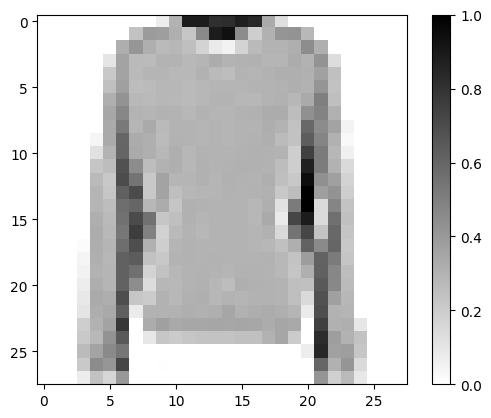

In [15]:
for imagen, etiqueta in datos_entrenamiento.take(1):
    break
imagen = imagen.numpy().reshape((28,28))

plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

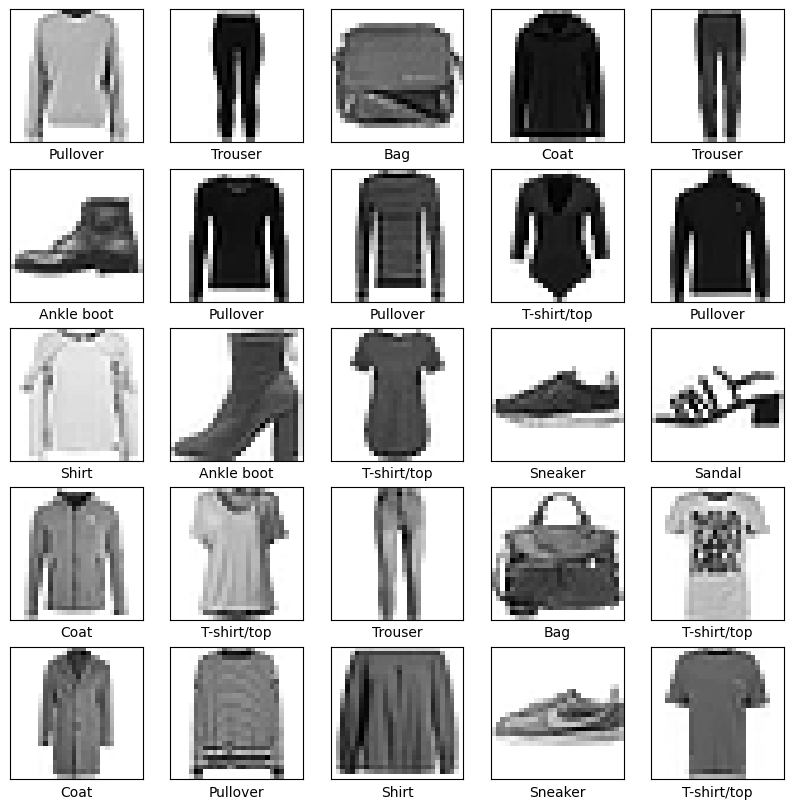

In [16]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    imagen = imagen.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen, cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [18]:
#Creación del modelo
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [21]:
TAMANO_LOTE = 32

In [22]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [25]:
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [26]:
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7602 - loss: 0.6848
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8597 - loss: 0.3938
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8723 - loss: 0.3523
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8781 - loss: 0.3336
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8817 - loss: 0.3187


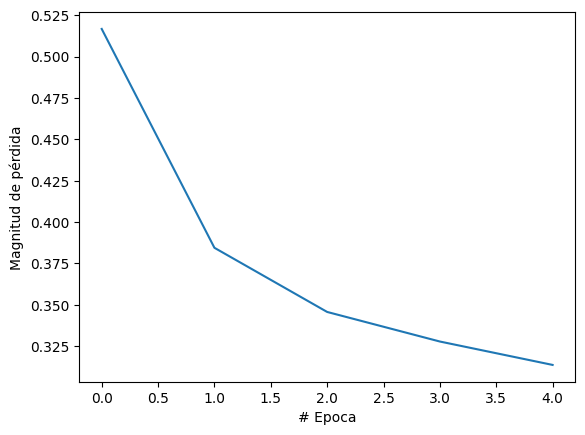

In [28]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])


In [29]:
# Crear una cuadrícula con varias predicciones, y marcar si fue correcta (azul)
for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
    imagenes_prueba = imagenes_prueba.numpy()
    etiquetas_prueba = etiquetas_prueba.numpy()

predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
    arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[..., 0], cmap=plt.cm.binary)

    etiqueta_prediccion = np.argmax(arr_predicciones)
    if etiqueta_prediccion == etiqueta_real:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                         100 * np.max(arr_predicciones),
                                         nombres_clases[etiqueta_real]),
               color=color)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


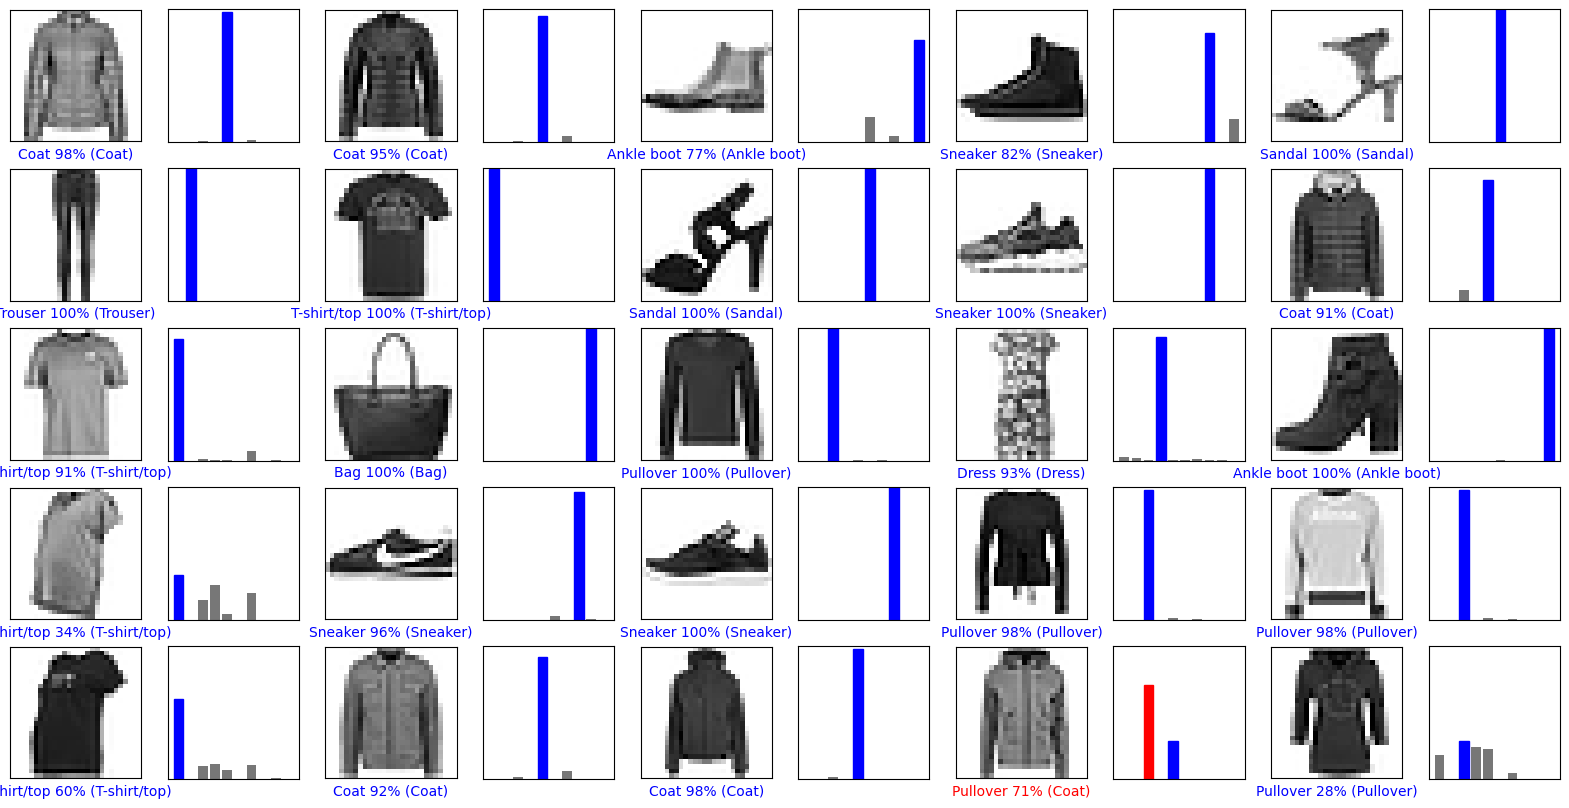

In [30]:
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
    arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    grafica = plt.bar(range(10), arr_predicciones, color="#777777")
    plt.ylim([0, 1])
    etiqueta_prediccion = np.argmax(arr_predicciones)

    grafica[etiqueta_prediccion].set_color('red')
    grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas * columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
    plt.subplot(filas, 2*columnas, 2*i+1)
    graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
    plt.subplot(filas, 2*columnas, 2*i+2)
    graficar_valor_arreglo(i, predicciones, etiquetas_prueba)


In [31]:
#Predicción
imagen = imagenes_prueba[24]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Predicción: " + nombres_clases[np.argmax(prediccion[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Predicción: Pullover


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


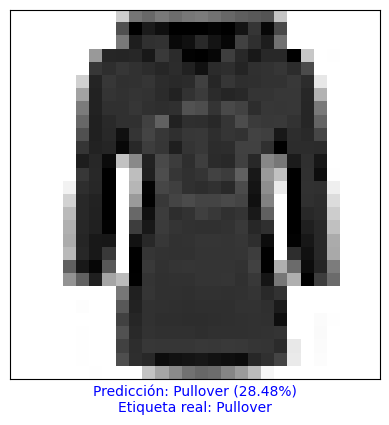

In [35]:
# Predicción de una imagen específica y visualización
imagen = imagenes_prueba[24]
imagen_expandida = np.array([imagen])  # Expandimos para que sea compatible con el modelo
prediccion = modelo.predict(imagen_expandida)

etiqueta_predicha = np.argmax(prediccion[0])
etiqueta_real = etiquetas_prueba[24]

plt.figure()
plt.imshow(imagen[..., 0], cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
color = 'blue' if etiqueta_predicha == etiqueta_real else 'red'
plt.xlabel("Predicción: {} ({:.2f}%)\nEtiqueta real: {}".format(
    nombres_clases[etiqueta_predicha],
    100 * np.max(prediccion[0]),
    nombres_clases[etiqueta_real]
), color=color)
plt.show()
